In [1]:
%matplotlib inline
import PIL
from PIL import ImageDraw, ImageFont
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import math
from tqdm import tqdm_notebook as tqdm
import f1
from importlib import reload
import stable.center_model
import stable.classifier
import stable.predict
import stable.utils
import shutil

In [2]:
DATA = Path("data")

train_fnames = (DATA/"train_fnames.txt").read_text().split("\n")
valid_fnames = (DATA/"valid_fnames.txt").read_text().split("\n")

df_train = pd.read_csv("data/train.csv")
unicode_map = {codepoint: char for codepoint, char in pd.read_csv('data/unicode_translation.csv').values}

sample_submission = pd.read_csv("data/sample_submission.csv")

## Create heatmaps for all train images and make random crops

In [3]:
make_heatmaps = False

In [4]:
if make_heatmaps:
    stable.center_model.generate_heatmap_crops_circular(
        im_path=DATA/"train_images",
        hm_save_path=DATA/"train_images_heatmaps",
        im_crop_save_path=DATA/"train_images_circular_1024->256",
        hm_crop_save_path=DATA/"train_images_heatmaps_circular_1024->256",
        df=df_train,
        overlap=512,
        crop_size=1024,
        resize_to=256,
        radius=25)

### That data might not have been enough. Make more data.

In [5]:
make_heatmaps = False

In [6]:
if make_heatmaps:
    stable.center_model.generate_heatmap_crops_circular(
        im_path=DATA/"train_images",
        hm_save_path=DATA/"train_images_heatmaps",
        im_crop_save_path=DATA/"train_images_circular_1024->256",
        hm_crop_save_path=DATA/"train_images_heatmaps_circular_1024->256",
        df=df_train,
        overlap=256,
        crop_size=1024,
        resize_to=256,
        radius=25)

### Dataset with no overlap

In [7]:
make_heatmaps = False

In [8]:
#!rm -r data/train_images_circular_lite

In [9]:
if make_heatmaps:
    stable.center_model.generate_heatmap_crops_circular(
        im_path=DATA/"train_images",
        hm_save_path=DATA/"train_images_heatmaps",
        im_crop_save_path=DATA/"train_images_circular_lite",
        hm_crop_save_path=DATA/"train_images_heatmaps_lite",
        df=df_train,
        overlap=1024,
        crop_size=1024,
        resize_to=256,
        radius=15)

### Make a mini dataset for experimentation :)

In [11]:
things = [p.name for p in (DATA/"train_images_circular_1024->256").ls()]

In [12]:
keep_fnames = things[:4000]

In [13]:
!rm -r data/train_images_mini
!rm -r data/train_images_heatmaps_mini
!mkdir data/train_images_mini/
!mkdir data/train_images_heatmaps_mini/
for f in keep_fnames:
    #!cp "data/train_images_circular_1024->256/"{f} data/train_images_mini/
    #!cp "data/train_images_heatmaps_circular_1024->256/"{f} data/train_images_heatmaps_mini
    shutil.copyfile(DATA/"train_images_circular_1024->256"/f,
                DATA/"train_images_mini"/f)
    shutil.copyfile(DATA/"train_images_heatmaps_circular_1024->256"/f,
                DATA/"train_images_heatmaps_mini"/f)

rm: cannot remove 'data/train_images_mini': No such file or directory
rm: cannot remove 'data/train_images_heatmaps_mini': No such file or directory


# Experiments

In [3]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [4]:
from fastai.vision import *
from fastai import layers

In [5]:
data = None; import gc; gc.collect()
learn_gen = None; gc.collect()

0

In [6]:
size = 256
bs = 16
tfms = get_transforms(do_flip=False, p_lighting=0.0, max_zoom=1.5) # Same as in best submission

data = (ImageImageList.from_folder(DATA/"train_images_circular_lite")
       .split_by_valid_func(lambda x: x.name[:-14] in valid_fnames)
       #.split_by_rand_pct(valid_pct=0.2)
       .label_from_func(lambda x: DATA/"train_images_heatmaps_lite"/(x.name), convert_mode="L")
       #.label_from_func(lambda x: DATA/"train_images_random_crops"/(x.name))
       .transform(tfms, tfm_y=True, size=size, resize_method=ResizeMethod.SQUISH)
       .databunch(bs=bs, num_workers=6)
       .normalize(imagenet_stats))

data.c = 1

In [6]:
size = 256
bs = 16
tfms = get_transforms(do_flip=False, p_lighting=0.0, max_zoom=1.5) # Same as in best submission

data = (ImageImageList.from_folder(DATA/"train_images_mini")
       #split_by_valid_func(lambda x: x.name[:-14] in valid_fnames)
       .split_by_rand_pct(valid_pct=0.2)
       .label_from_func(lambda x: DATA/"train_images_heatmaps_mini"/(x.name), convert_mode="L")
       .transform(tfms, tfm_y=True, size=size, resize_method=ResizeMethod.SQUISH)
       .databunch(bs=bs, num_workers=6)
       .normalize(imagenet_stats))

data.c = 1

In [7]:
# https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938


from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss


In [44]:
def center_detection_accuracy(preds, targets):
    print(preds)
    print(targets)
    for pred, target in zip(preds, targets):
        pass
    return torch.Tensor(1)
    
def create_gen_learner():
    learn = unet_learner(data, models.resnet18, callback_fns=[ShowGraph,
                                                          partial(callbacks.MixedPrecision, loss_scale=1024),
                                                          callbacks.CSVLogger,
                                                          #callbacks.ReduceLROnPlateauCallback
                                                         ],
                    metrics=[mean_squared_error, mean_absolute_error
                            #center_detection_accuracy
                            ],
                    blur=True, norm_type=NormType.Weight, self_attention=True)
    #learn.loss_func = mean_squared_error
    #learn.loss_func = FocalLoss(alpha=0.25, gamma=2)
    learn.loss_func = F.binary_cross_entropy_with_logits
    return learn

In [9]:
learn_gen = None; gc.collect()

60

In [10]:
learn_gen = create_gen_learner()

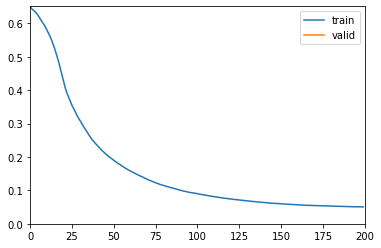

In [12]:
learn_gen.fit_one_cycle(1, 1e-4)

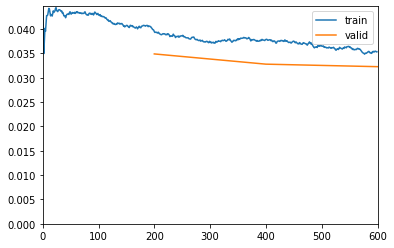

In [14]:
learn_gen.fit_one_cycle(3, 1e-4)

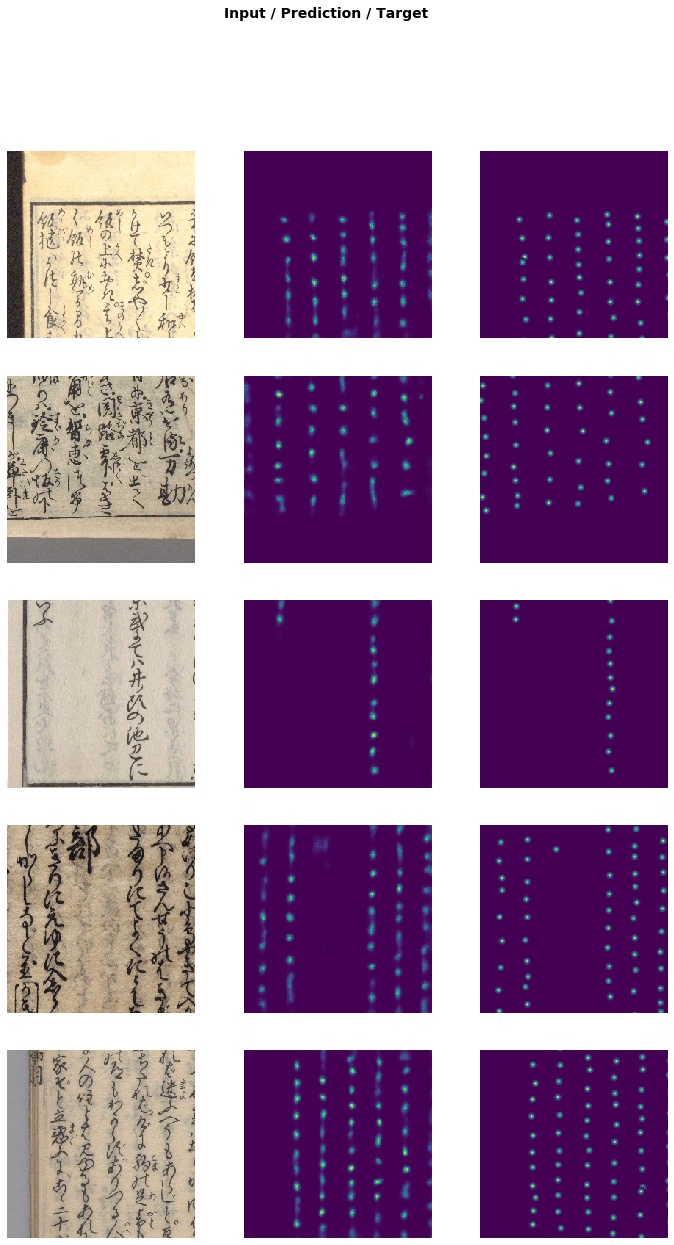

In [16]:
learn_gen.show_results()

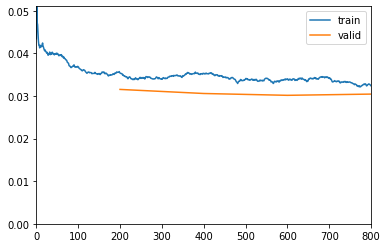

In [17]:
learn_gen.fit(4, 1e-4)

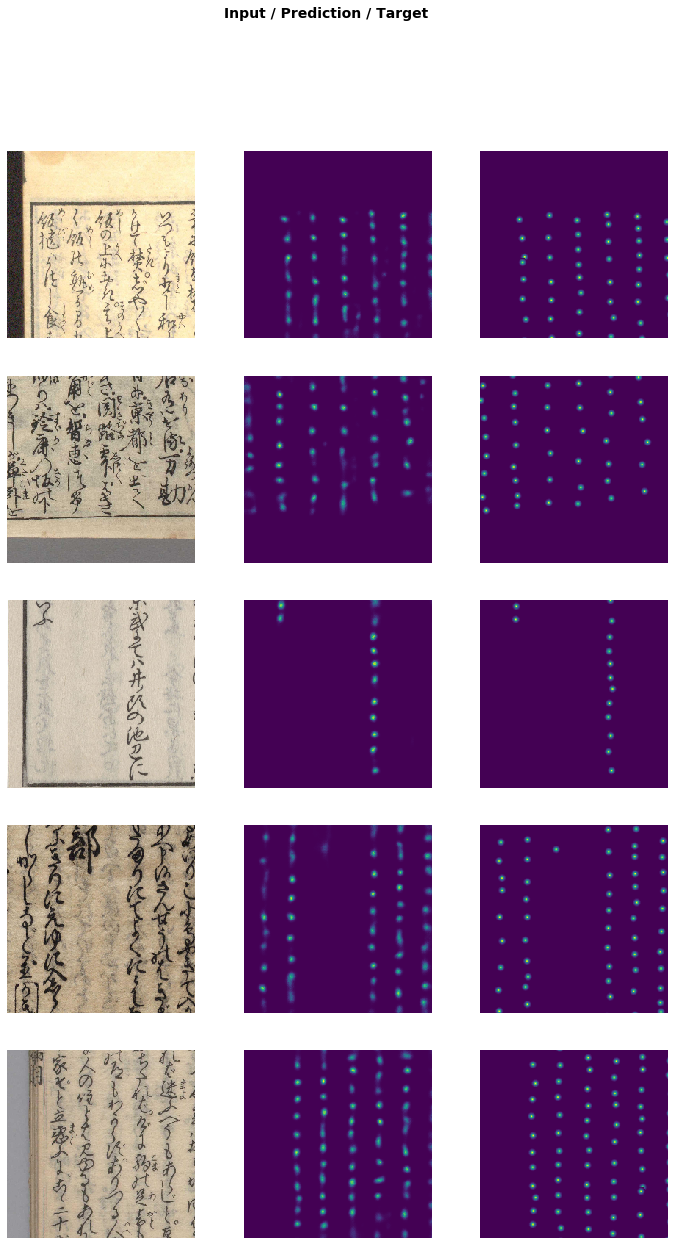

In [18]:
learn_gen.show_results()

In [19]:
learn_gen.unfreeze()

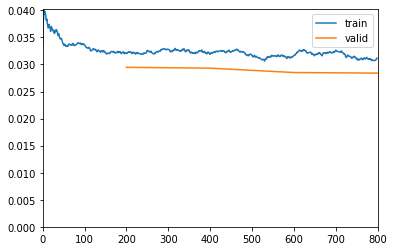

In [20]:
learn_gen.fit(4, 1e-4)

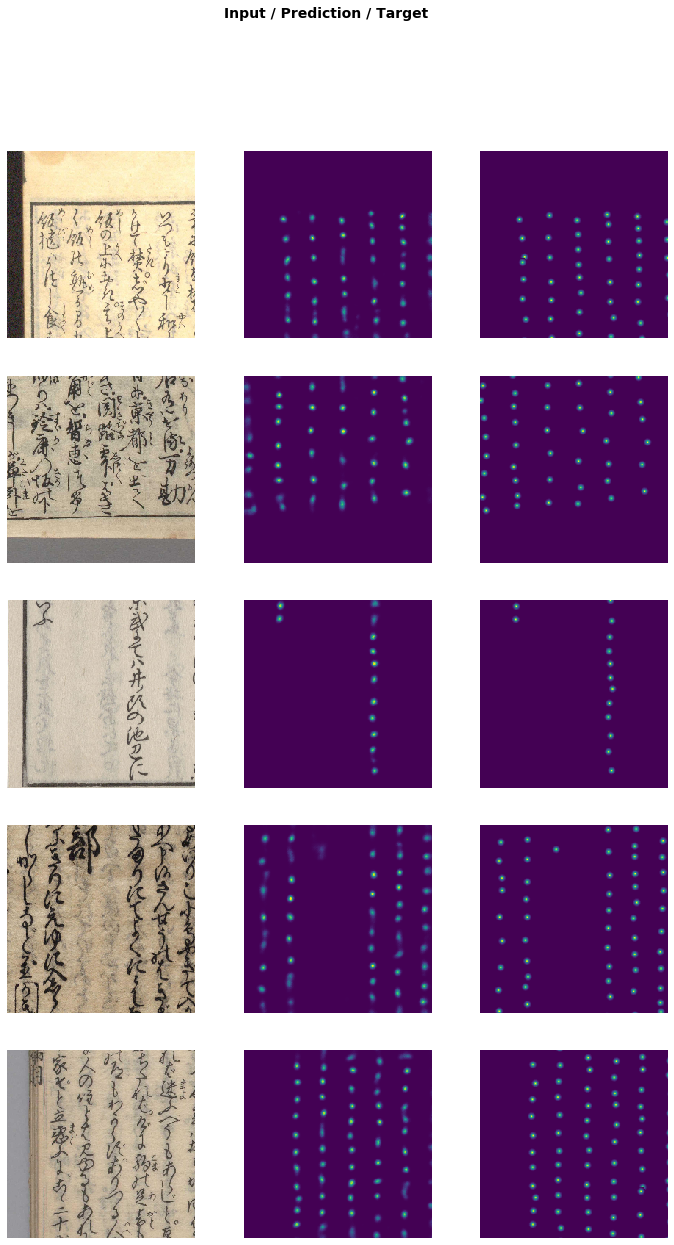

In [21]:
learn_gen.show_results()

In [22]:
learn_gen.save("stage-1")

In [23]:
learn_gen = learn_gen.load("stage-1")

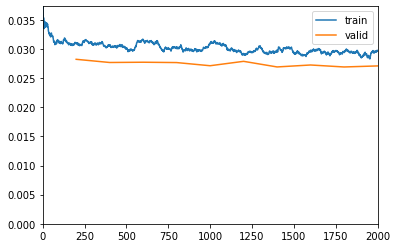

In [24]:
learn_gen.fit(10, 1e-4)

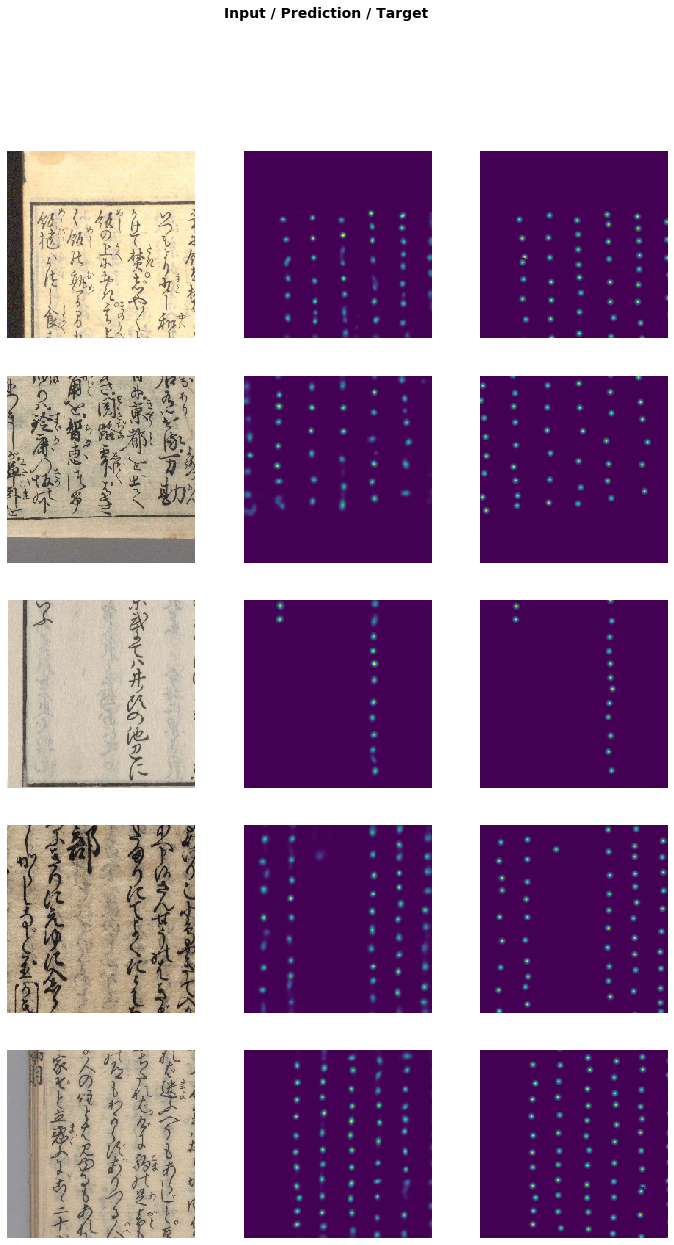

In [25]:
learn_gen.show_results()

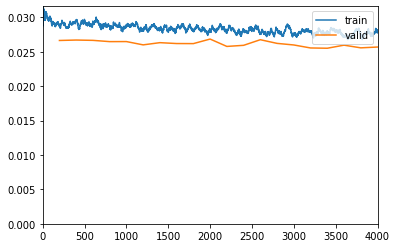

In [26]:
learn_gen.fit(20, 1e-4)

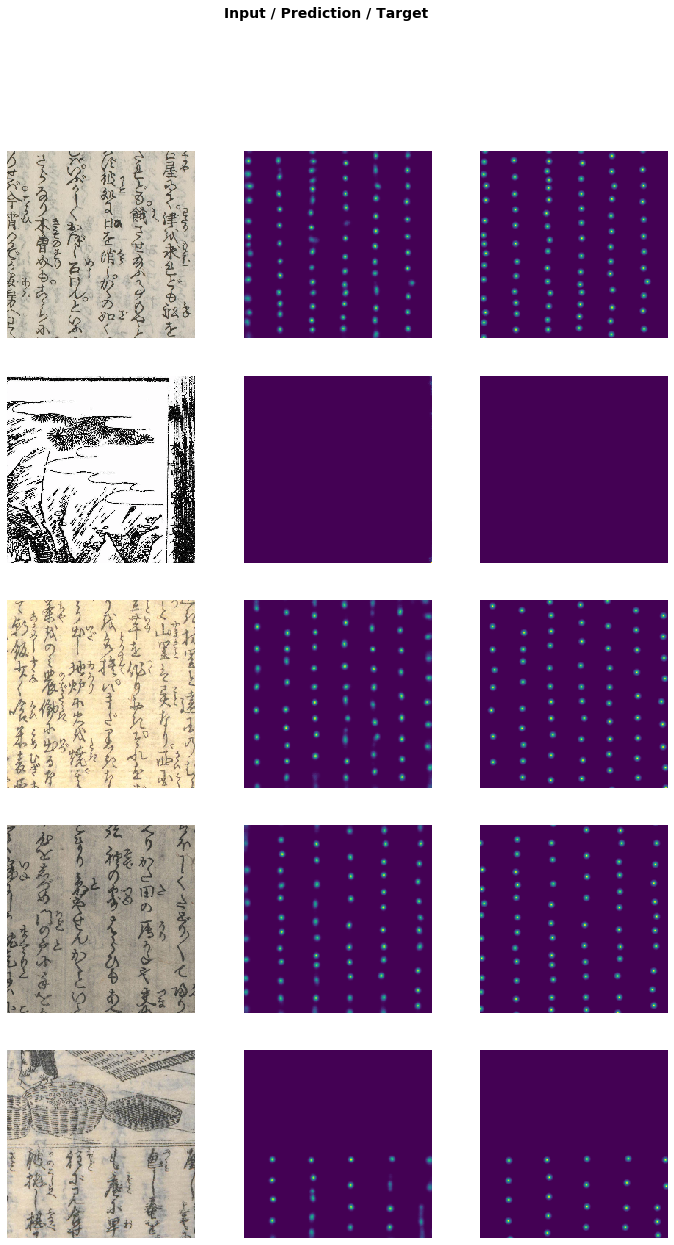

In [27]:
learn_gen.show_results(20)

In [28]:
learn_gen.save("stage2")

In [45]:
data = None; import gc; gc.collect()
learn_gen = None; gc.collect()

0

In [46]:
size = 256
bs = 16
tfms = get_transforms(do_flip=False, p_lighting=0.0, max_zoom=1.5) # Same as in best submission

data = (ImageImageList.from_folder(DATA/"train_images_circular_1024->256")
       .split_by_valid_func(lambda x: x.name[:-14] in valid_fnames)
       #.split_by_rand_pct(valid_pct=0.2)
       .label_from_func(lambda x: DATA/"train_images_heatmaps_circular_1024->256"/(x.name), convert_mode="L")
       #.label_from_func(lambda x: DATA/"train_images_random_crops"/(x.name))
       .transform(tfms, tfm_y=True, size=size, resize_method=ResizeMethod.SQUISH)
       .databunch(bs=bs, num_workers=6)
       .normalize(imagenet_stats))

data.c = 1

In [47]:
learn_gen = create_gen_learner()

In [48]:
learn_gen.loss_func

<function torch.nn.functional.binary_cross_entropy_with_logits(input, target, weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None)>

In [49]:
learn_gen = learn_gen.load("../../train_images_mini/models/stage2")

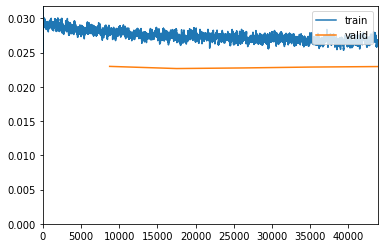

In [50]:
learn_gen.fit(5, 1e-4)

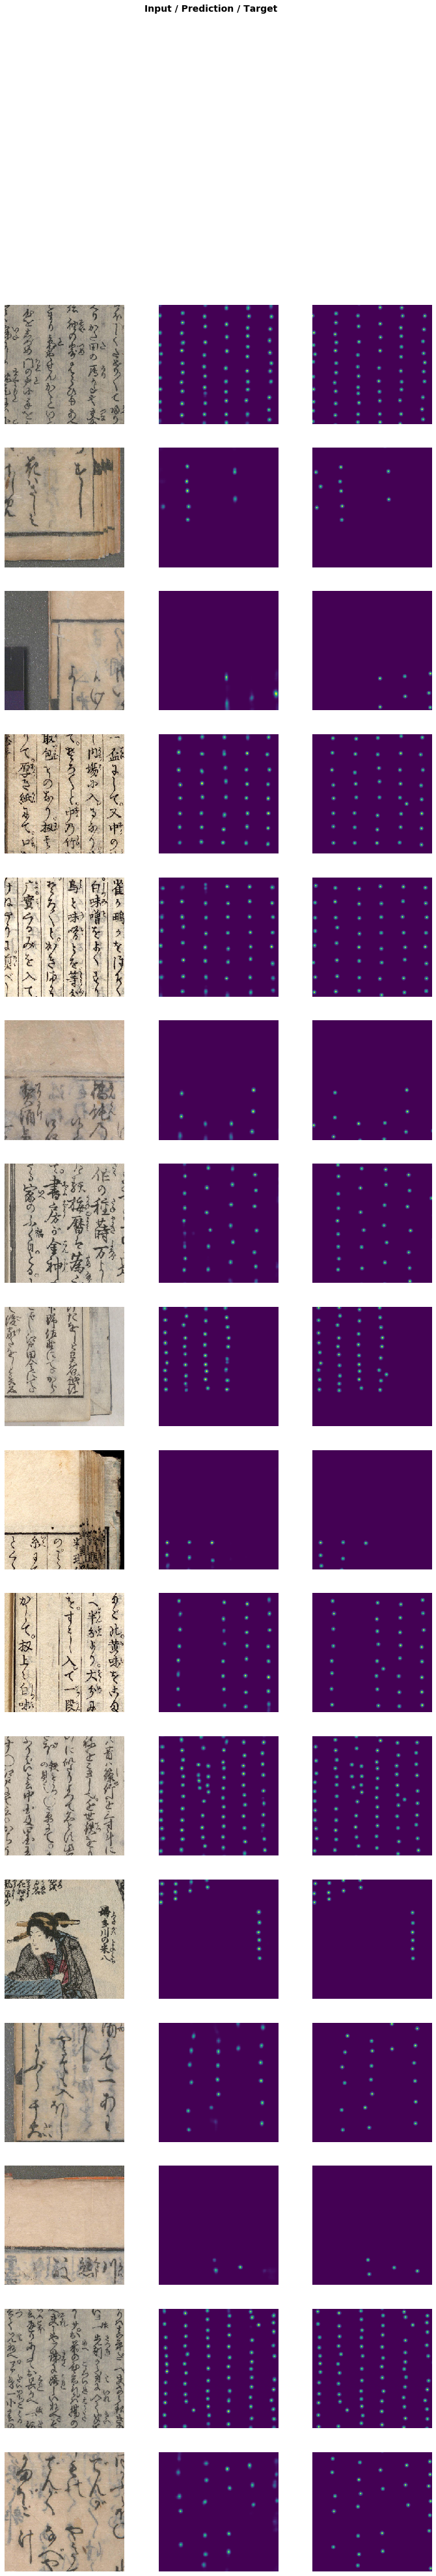

In [51]:
learn_gen.show_results(rows=20)

In [54]:
learn_gen.save("stage3")

# Inference

In [64]:
learn = learn_gen

In [65]:
import skimage.feature
import stable.utils; import stable.predict

classifier = load_learner(path=DATA/"train_images_chars_256", file="20190906_classifier-50-epochs").to_fp32()

def extract_peaks(heatmap, min_distance, threshold_abs):
    # cheers https://stackoverflow.com/questions/51672327/skimage-peak-local-max-finds-multiple-spots-in-close-proximity-due-to-image-impu
    heatmap_gray = np.array(PIL.Image.fromarray(heatmap).convert("L"))
    is_peak = skimage.feature.peak_local_max(heatmap_gray, min_distance=min_distance, indices=False, threshold_abs=threshold_abs, exclude_border=False) # add exclude_border
    labels = scipy.ndimage.measurements.label(is_peak)[0]
    merged_peaks = scipy.ndimage.measurements.center_of_mass(is_peak, labels, range(1, np.max(labels)+1))
    return np.array(merged_peaks)

def sliding_crop_generator(im, crop_size, valid_window_size, stride):
    height, width = im.shape[:2]
    margin = (crop_size - valid_window_size) // 2
    
    for x_i in range(ceil((width - valid_window_size) / stride) + 1):
        for y_i in range(ceil((height - valid_window_size) / stride) + 1):
            x_offset = (x_i * stride)
            y_offset = (y_i * stride)
            
            x0, y0 = x_offset, y_offset
            
            if x0 - margin < 0:
                left_pad = margin - x0
                x0 = 0
            else:
                left_pad = 0
                x0 = x0 - margin
        
            if y0 - margin < 0:
                top_pad = margin - y0
                y0 = 0
            else:
                top_pad = 0
                y0 = y0 - margin
            
            if  x_offset + crop_size > width:
                right_pad = x_offset + crop_size - width
                x1 = width
            else:
                right_pad = 0
                x1 = x_offset + crop_size
            
            if y_offset + crop_size > height:
                bottom_pad = y_offset + crop_size - height
                y1 = height
            else:
                bottom_pad = 0
                y1 = y_offset + crop_size
            
            crop = im[y0:y1, x0:x1]
            crop = np.pad(crop, [[top_pad, bottom_pad], [left_pad, right_pad], [0,0]], "constant", constant_values=0)
            yield crop, [x0,x1,y0,y1]
            

def get_centers_old_fix(im, model, hm_threshold=10, hm_min_distance=25):
    im = np.asarray(im)
    block_size = 1024 # was 512 # net takes 256x256 resize of 512x512 block
    model_input_size = 256
    channels = 3
    im_height, im_width = im.shape[:2]
    hm_height, hm_width = im_height // 2, im_width // 2
    blocks = stable.utils.get_image_blocks(im, block_size)
    heatmap = np.zeros([hm_height, hm_width, im.shape[2]], dtype=np.uint8)
    
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            hm_tile = stable.predict.process_output(model.predict(stable.predict.preprocess_input(blocks[i,j])))
            if (i+1) * 256 > hm_height:
                hm_tile = hm_tile[:hm_height%256,:]
            if (j+1) * 256 > hm_width:
                hm_tile = hm_tile[:,:hm_width%256]
            try:
                heatmap[256*i:256*(i+1),256*j:256*(j+1)] = hm_tile
            except Exception as e:
                print(i, j)
                print(heatmap.shape)
                print(hm_tile.shape)
                print(hm_tile)
                raise(e)
            
    # cheers https://stackoverflow.com/questions/51672327/skimage-peak-local-max-finds-multiple-spots-in-close-proximity-due-to-image-impu
    heatmap_gray = np.array(PIL.Image.fromarray(heatmap).convert("L"))
    is_peak = skimage.feature.peak_local_max(heatmap_gray, min_distance=hm_min_distance, indices=False, threshold_abs=hm_threshold,  exclude_border=False)
    labels = scipy.ndimage.measurements.label(is_peak)[0]
    merged_peaks = scipy.ndimage.measurements.center_of_mass(is_peak, labels, range(1, np.max(labels)+1))
    merged_peaks = np.array(merged_peaks) * (block_size / model_input_size)  # scale up to same dimensions as original image
    if len(merged_peaks) > 0:
        merged_peaks[:,[0,1]] = merged_peaks[:,[1,0]]  # for some reason merged_peaks was (y, x) coords
    return merged_peaks

In [66]:
valid_truth = pd.DataFrame(df_train[df_train.image_id.isin([name for name in valid_fnames])].values,
                           columns=["image_id", "labels"])
# Sorry for not knowing how to pandas

valid_preds = valid_truth.copy()
for i in range(len(valid_preds)):
    valid_preds.iloc[i].labels = np.nan

In [71]:
def predict_page(im_arr):
    im_height, im_width, colour_depth = im_arr.shape
    # for now just a square area around center
    r=128  # 256x256
    
    predictions = []
        
    centers = get_centers_old_fix(im, learn, hm_threshold=20, hm_min_distance=10)#, stride=1024) # stride 896 was used previously

    if centers is not None:
#         for j in range(len(centers)):
#             for k in range(j + 1, len(centers)):
#                 if np.linalg.norm(centers[j] - centers[k]) < min_distance:
#                     centers[k] = [-100, -100]
        
#         centers = centers[np.all(centers != [-100, -100], axis=1)]

        for center_x, center_y in centers:
            center_x = int(center_x)
            center_y = int(center_y)
            x0, y0 = max(0, center_x - r), max(0, center_y - r)
            x1, y1 = center_x + r, center_y + r
            character_region = im_arr[y0:y1, x0:x1]
            prediction = classifier.predict(stable.predict.preprocess_input(character_region))[0].obj
            if prediction != "BACKGROUND":
                predictions.append([prediction, center_x, center_y])
                
        # new
#         for j in range(len(predictions)):
#             for k in range(j+1, len(predictions)):
#                 if predictions[j] is not None and predictions[k] is not None:
#                     if (predictions[j][1] - predictions[k][1]) ** 2 + (predictions[j][2] - predictions[k][2]) ** 2 < min_distance ** 2:
#                         if predictions[j][0] == predictions[k][0]:
#                             # check if class is same
#                             predictions[k] = None
#         predictions = [p for p in predictions if p is not None]

    return predictions

In [72]:
for i in tqdm(range(len(valid_preds))):
    fname = valid_preds.iloc[i].image_id
    im = PIL.Image.open(DATA/"train_images"/f"{fname}.jpg")
    im_arr = np.array(im)
    
    predictions = predict_page(im_arr)
    
    if len(predictions) > 0:
        predictions_str = " ".join([" ".join(map(str, i)) for i in predictions])
        valid_preds.iloc[i].labels = predictions_str
    else:
        valid_preds.iloc[i].labels = np.nan
        
    if i % 50 == 0:
        print(f1.kuzushiji_f1(valid_preds[:i+1], valid_truth[:i+1], detection_only=False),
              f1.kuzushiji_f1(valid_preds[:i+1], valid_truth[:i+1], detection_only=True))

0.608695652173913 0.8260869565217392
0.9268825595005853 0.9835349200156067


KeyboardInterrupt: 